In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/html-2024-fall-final-project-stage-1/same_season_sample_submission.csv
/kaggle/input/html-2024-fall-final-project-stage-1/README.md
/kaggle/input/html-2024-fall-final-project-stage-1/train_data.csv
/kaggle/input/html-2024-fall-final-project-stage-1/same_season_test_data.csv


In [7]:
# fundamental tool
import numpy as np
import pandas as pd

# model and data processing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [8]:
# read training data
train_data = pd.read_csv('/kaggle/input/html-2024-fall-final-project-stage-1/train_data.csv')

# read testing data
test_data = pd.read_csv('/kaggle/input/html-2024-fall-final-project-stage-1/same_season_test_data.csv')

# read testing sample
sample_submission = pd.read_csv('/kaggle/input/html-2024-fall-final-project-stage-1/same_season_sample_submission.csv')

In [9]:
print("Training Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)
print("Sample Submission Shape:", sample_submission.shape)

Training Data Shape: (11067, 167)
Test Data Shape: (6185, 165)
Sample Submission Shape: (6185, 2)


In [10]:
print("Training Data Columns:\n", train_data.dtypes)
print("Test Data Columns:\n", test_data.dtypes)

Training Data Columns:
 id                                        int64
home_team_abbr                           object
away_team_abbr                           object
date                                     object
is_night_game                            object
                                         ...   
away_pitcher_leverage_index_avg_std     float64
away_pitcher_leverage_index_avg_skew    float64
away_pitcher_wpa_def_mean               float64
away_pitcher_wpa_def_std                float64
away_pitcher_wpa_def_skew               float64
Length: 167, dtype: object
Test Data Columns:
 id                                        int64
home_team_abbr                           object
away_team_abbr                           object
is_night_game                            object
home_pitcher                             object
                                         ...   
away_pitcher_leverage_index_avg_std     float64
away_pitcher_leverage_index_avg_skew    float64
away_pitcher_wpa_

In [11]:
print("Missing Values in Train Data:\n", train_data.isnull().sum())
print("Missing Values in Test Data:\n", test_data.isnull().sum())

Missing Values in Train Data:
 id                                         0
home_team_abbr                             0
away_team_abbr                             0
date                                       0
is_night_game                            553
                                        ... 
away_pitcher_leverage_index_avg_std     1974
away_pitcher_leverage_index_avg_skew    2646
away_pitcher_wpa_def_mean               1296
away_pitcher_wpa_def_std                1960
away_pitcher_wpa_def_skew               2647
Length: 167, dtype: int64
Missing Values in Test Data:
 id                                        0
home_team_abbr                            0
away_team_abbr                            0
is_night_game                           309
home_pitcher                            309
                                       ... 
away_pitcher_leverage_index_avg_std     453
away_pitcher_leverage_index_avg_skew    533
away_pitcher_wpa_def_mean               371
away_pitcher_wpa_def_s

In [12]:
columns_to_drop = ['id', 'date', 'home_pitcher', 'away_pitcher']

# drop some column
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print("Train Data Shape after Dropping Columns:", train_data.shape)
print("Test Data Shape after Dropping Columns:", test_data.shape)

Train Data Shape after Dropping Columns: (11067, 163)
Test Data Shape after Dropping Columns: (6185, 162)


In [13]:
# 1. missing rate checking
train_missing = train_data.isnull().sum()
test_missing = test_data.isnull().sum()

# 2. delete the column of high missing rate（>50%）
high_missing_columns = train_missing[train_missing > 0.5 * len(train_data)].index
train_data.drop(columns=high_missing_columns, inplace=True)
test_data.drop(columns=high_missing_columns, inplace=True)

# 3. fill numerical columns
numerical_columns = train_data.select_dtypes(include=['number']).columns
train_data[numerical_columns] = train_data[numerical_columns].fillna(train_data[numerical_columns].mean())
test_data[numerical_columns] = test_data[numerical_columns].fillna(train_data[numerical_columns].mean())

# 4. fill objective columns
categorical_columns = train_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)
    if col in test_data.columns:
        test_data[col].fillna(train_data[col].mode()[0], inplace=True)

print("Remaining missing values in training data:", train_data.isnull().sum().sum())
print("Remaining missing values in testing data:", test_data.isnull().sum().sum())


Remaining missing values in training data: 0
Remaining missing values in testing data: 0


/tmp/ipykernel_30/2170478990.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(train_data[col].mode()[0], inplace=True)
/tmp/ipykernel_30/2170478990.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [14]:
# One-Hot Encoding 
categorical_columns = train_data.select_dtypes(include=['object']).columns
train_data = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)




In [15]:
# 構造特徵：休息天數差
train_data['rest_days_diff'] = train_data['home_team_rest'] - train_data['away_team_rest']
test_data['rest_days_diff'] = test_data['home_team_rest'] - test_data['away_team_rest']

# 構造特徵：打擊率差
train_data['batting_avg_diff'] = train_data['home_batting_batting_avg_10RA'] - train_data['away_batting_batting_avg_10RA']
test_data['batting_avg_diff'] = test_data['home_batting_batting_avg_10RA'] - test_data['away_batting_batting_avg_10RA']

In [16]:
# 分割特徵與目標變數
X = train_data.drop(columns=['home_team_win'])  # 'home_team_win' 是目標
y = train_data['home_team_win']

# 查看數據形狀
print("Feature Data Shape:", X.shape)
print("Target Data Shape:", y.shape)

Feature Data Shape: (11067, 636)
Target Data Shape: (11067,)


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# First Random Forest Model used to test the best max_depth
rf_model = RandomForestClassifier(
    n_estimators=1500,  # number of tree
    max_depth=None,    # max_depth
    random_state=11    # random seedd
)

# 定義範圍
param_grid = {'max_depth': [5, 10, 15, 20, 25, None]}  # None 表示不限制深度

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# 輸出最佳參數和模型效能
print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best accuracy:", grid_search.best_score_)

Best max_depth: 5
Best accuracy: 0.5571499364639678


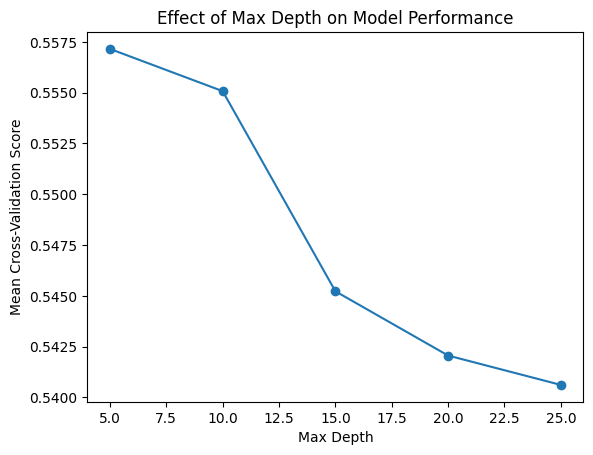

In [18]:
import matplotlib.pyplot as plt

results = pd.DataFrame(grid_search.cv_results_)
param_values = results['param_max_depth']
mean_scores = results['mean_test_score']

plt.plot(param_values, mean_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Cross-Validation Score')
plt.title('Effect of Max Depth on Model Performance')
plt.show()


In [19]:
import joblib

# 獲取最佳模型
best_model = grid_search.best_estimator_

# 保存最佳模型（可選）
joblib.dump(best_model, 'best_model.pkl')

# 預測測試集
predictions_with_best_depth = best_model.predict(test_data)

sample_submission['home_team_win'] = predictions_with_best_depth  # 替換目標列的值
sample_submission.to_csv('rf_1500_with_best_depth.csv', index=False)  # 保存為 CSV 文件

print("Submission file saved as 'rf_1500_with_best_depth.csv'.")


Submission file saved as 'rf_1500_with_best_depth.csv'.


In [20]:
rf_model2 = RandomForestClassifier(
    n_estimators=1750,  # number of tree
    max_depth=10,    # max_depth
    random_state=11    # random seedd
)

cv_scores = cross_val_score(rf_model2, X, y, cv=5, scoring='accuracy')

# 打印每一折的評估結果和平均準確率
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
rf_model2.fit(X, y)

y_pred_test = rf_model2.predict(test_data)
print("Test Predictions (first 10):", y_pred_test[:10])

sample_submission['home_team_win'] = y_pred_test  # 替換目標列的值
sample_submission.to_csv('rf_1500_depth10.csv', index=False)  # 保存為 CSV 文件

print("Submission file saved as 'rf_1500_depth10.csv'.")

Cross-validation scores: [0.55691057 0.56729901 0.54902847 0.55896972 0.54179846]
Mean cross-validation score: 0.5548012463103995
Test Predictions (first 10): [ True False  True False False  True  True False False  True]
Submission file saved as 'rf_1500_depth10.csv'.


Top 10 important features:
 away_pitching_SO_batters_faced_mean    0.010860
away_pitching_SO_batters_faced_10RA    0.010342
home_team_spread_mean                  0.009504
away_team_spread_mean                  0.009061
home_team_wins_mean                    0.008426
home_pitching_earned_run_avg_mean      0.008386
away_team_wins_skew                    0.008337
away_pitching_earned_run_avg_mean      0.008328
away_batting_onbase_perc_mean          0.008151
away_pitcher_SO_batters_faced_mean     0.008073
dtype: float64
Bottom 10 important features:
 home_team_season_ATL_2023    0.000041
away_team_season_SFG_2021    0.000041
home_team_season_SDP_2023    0.000041
home_team_season_TBR_2018    0.000041
away_team_season_TBR_2021    0.000041
                               ...   
home_team_season_CIN_2021    0.000015
home_team_season_DET_2016    0.000015
home_team_season_STL_2016    0.000014
away_team_season_PHI_2018    0.000014
away_team_season_CHC_2023    0.000013
Length: 300, dtype: float64


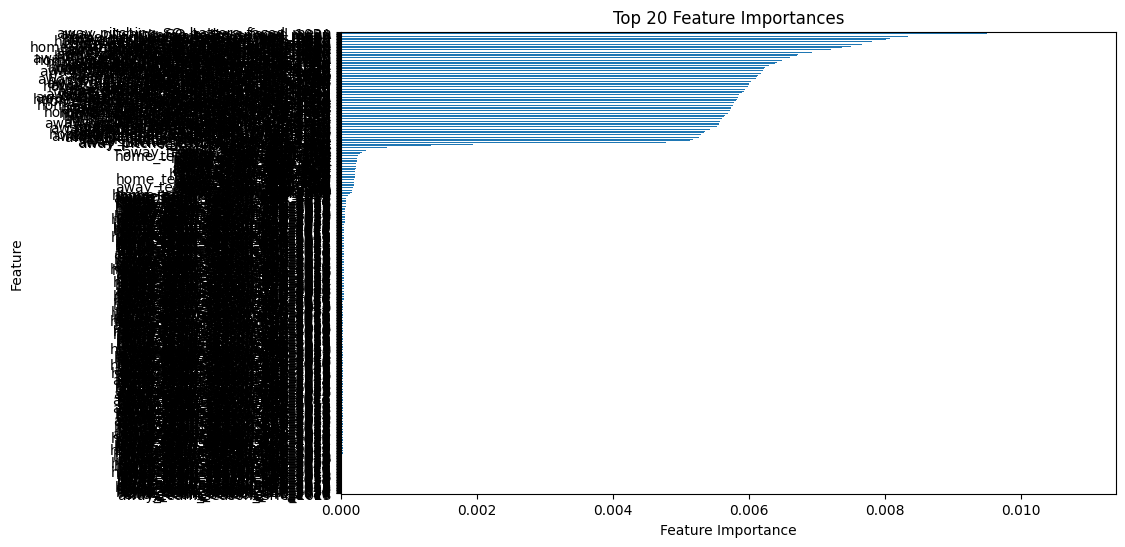

In [21]:
import matplotlib.pyplot as plt
feature_scores = pd.Series(rf_model2.feature_importances_, index=X.columns).sort_values(ascending=False)

# 找出重要性最高的 10 個特徵
top_10_features = feature_scores.head(10)
print("Top 10 important features:\n", top_10_features)

bottom_10_features = feature_scores.tail(300)
print("Bottom 10 important features:\n", bottom_10_features)

feature_importances = pd.Series(rf_model2.feature_importances_, index=X.columns)

# 按重要性排序
sorted_importances = feature_importances.sort_values(ascending=False)

# 繪製條形圖
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh')  # 僅顯示前 20 個特徵
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # 翻轉 Y 軸
plt.show()

In [22]:
important_features = feature_importances[feature_importances >= 0.001]

# 打印剩餘的特徵數量和名稱
print(f"Number of important features: {len(important_features)}")

# 篩選 X_train 和 X_test 中的列
X_train_filtered = X[important_features.index]
X_test_filtered = test_data[important_features.index]

# 檢查篩選後數據的形狀
print("Shape of filtered X_train:", X_train_filtered.shape)
print("Shape of filtered X_test:", X_test_filtered.shape)

Number of important features: 159
Shape of filtered X_train: (11067, 159)
Shape of filtered X_test: (6185, 159)


In [23]:
rf_model3 = RandomForestClassifier(
    n_estimators=1550,  # 樹的數量
    max_depth=10,    # 最大深度
    random_state=11 ,   # 固定隨機種子
    oob_score = True
)
cv_scores = cross_val_score(rf_model3, X_train_filtered, y, cv=5, scoring='accuracy')

# 打印每一折的評估結果和平均準確率
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
rf_model3.fit(X_train_filtered, y)
print("OOB Score:", rf_model3.oob_score_)

y_pred_test = rf_model3.predict(X_test_filtered)
print("Test Predictions (first 10):", y_pred_test[:10])

sample_submission['home_team_win'] = y_pred_test  # 替換目標列的值
sample_submission.to_csv('rf2_1750_10_17.csv', index=False)  # 保存為 CSV 文件

print("Submission file saved as 'rf2_1750_10_17.csv'.")

Cross-validation scores: [0.55103884 0.56052394 0.54044284 0.55671035 0.54270221]
Mean cross-validation score: 0.5502836364408229
OOB Score: 0.5511882172223728
Test Predictions (first 10): [ True False  True False False  True  True False False  True]
Submission file saved as 'rf2_1750_10_17.csv'.
